In [2]:
# %load_ext autoreload
# %autoreload 2

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas
import datetime
import time, json, requests, pprint, copy, math, dateutil
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh
import scipy.interpolate
import seaborn as sns
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from Exploring_Argo_BGC_with_Argovis_helpers import polygon_lon_lat,  padlist, varrange, interpolate, \
    simple_map, plot_xycol, argo_heatmap, hurrplot, compare_plots
from dataclasses import dataclass, field
from typing import Dict

sns.set_style("darkgrid")

API_KEY='3e2bda40368d095888a54898b2f52c1fa50df102'
API_PREFIX = 'https://argovis-api.colorado.edu/'
API_KEY='3e2bda40368d095888a54898b2f52c1fa50df102'
API_PREFIX = 'https://argovis-api.colorado.edu/'

Download all the BGC measurements in a region over a timespan and plot the profile locations on a map:

In [3]:
def dfRead(dataSetName) :
    # Read dataframe from CSV file
    dfCSV = dataSetName+'_dfm.csv'
    print(dfCSV)
    dfm = pd.read_csv(dfCSV)
    dfm.wmoid = dfm.wmoid.astype('category')

    dfmapCSV = dataSetName+'_dfmap.csv'
    dfmap = pd.read_csv(dfmapCSV)
    dfmap.wmoid = dfmap.wmoid.astype('category')

    # print(dfm.tail())

    return (dfm, dfmap)


def dfSave(dataSetName, dfm, dfmap) :

    # Save dataframe to CSV file
    dfCSV = dataSetName+'_dfm.csv'
    print(dfCSV)
    dfm.to_csv(dfCSV)
    dfmapCSV = dataSetName+'_dfmap.csv'
    dfmap.to_csv(dfmapCSV)

def getProfilesFromPolygon(polygon, startDate, endDate, platform_type ):

    # Set up Argovis query parameters
    params = {
            'startDate': startDate,
            'endDate':   endDate,
            'source': 'argo_bgc',
            'polygon': eval(polygon),
            'data': 'cdom,salinity,temperature',
            'platform_type' : platform_type
        } 
    print(params)

    # Make the query. Returns a list of JSON instances, one per profile
    dd = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

    # Create a dataframe from each profile JSON string (dfs is an array of dataframes)
    dfs = [pd.DataFrame.from_records([level for level in avh.data_inflate(profile)]) for profile in dd]

    # Pull out data from JSON data set that's not in the profile data
    # Used for plotting / forensics
    # dfs = [pd.DataFrame.from_records([level for level in avh.data_inflate(profile)]) for profile in dd]

    # Two accumulating data frames: dfm for profile data, dfmap for profile location
    dfm = pd.DataFrame([])
    dfmap = pd.DataFrame([])

    Nprof = len(dd)
    Ncdom = 0
    ptc = PlatformTypeCache()

    for profile,df in zip(dd, dfs):
        dfp['salinity']=df['salinity']
        if 'cdom' in df.columns :
            Ncdom = Ncdom + 1
    
            dfp = pd.DataFrame([])
            platform_type = ptc.query(profile)
            dfp['salinity']=df['salinity']
            dfp['temperature']=df['temperature']
            dfp['cdom']=df['cdom']
            dfp['pressure']=df['pressure']
            dfp['id'] = profile['_id']
            dfp['wmoid'] = profile['_id'][0:7]
            dfp['platform_type'] = platform_type
            dfp['year'] = profile['timestamp'][0:4]
            dfm = pd.concat([dfm, dfp], axis=0)

            

            dfp = pd.DataFrame({'_id' : profile['_id'], \
                            'wmoid' : profile['_id'][0:7], \
                            'year'  : profile['timestamp'][0:4], \
                            'lon'   : profile['geolocation']['coordinates'][0], \
                            'lat'   : profile['geolocation']['coordinates'][1]}, index=[Ncdom-1]) 
            dfmap = pd.concat([dfmap, dfp])

    # Data from all profiles retrieved and in dataframe dfm.  
    print(f'N profiles = {Nprof}')
    print(f'Ncdom profiles = {Ncdom}')
    return (dfm, dfmap)


def getProfilesFromFloats(platforms, startDate, endDate, doCorrection=False, CorrectionFactor=[], ScalingFactor=[]) :

    platforms_choke = []


    nowiso = datetime.utcnow().replace(microsecond=0).isoformat()
    if endDate == '':
        endDate = nowiso+'Z'


    dd = list()

    for platform in platforms :
        print(platform)
        params = {
            'startDate': startDate,
            'endDate':   endDate,
            'platform': platform,
            'data': 'cdom,salinity,temperature',
            'source': 'argo_bgc'
        }
        print(params)
        d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)
        dd.extend(d)
    
    # Create a dataframe from each profile JSON string (dfs is an array of dataframes)
    dfs = [pd.DataFrame.from_records([level for level in avh.data_inflate(profile)]) for profile in dd]
        # dffs.extend(df)
        
    # print(dfs[0].head(5))
    # print(dfs[-1].head(5))

    #  Pull out data from JSON data set that's not in the profile data
    # Used for plotting / forensics
    # dfs = [pd.DataFrame.from_records([level for level in avh.data_inflate(profile)]) for profile in dd]

    # Two accumulating data frames: dfm for profile data, dfmap for profile location
    dfm = pd.DataFrame([])
    dfmap = pd.DataFrame([])

    Nprof = len(dd)
    Ncdom = 0
    ptc = PlatformTypeCache()

    for profile,df in zip(dd, dfs):
        if 'cdom' in df.columns :
            Ncdom = Ncdom + 1
    
        
            # print(Ncdom, wmoid, iwmo, CF)
            
            dfp = pd.DataFrame([])
            platform_type = ptc.query(profile)
            dfp['cdom']=df['cdom']
            dfp['salinity']=df['salinity']
            dfp['temperature']=df['temperature']

            if doCorrection :
                wmoid = int(profile['_id'][0:7])
                iwmo = np.where(platforms == wmoid)[0][0]
                CF = CorrectionFactor[iwmo]
                SF = ScalingFactor[iwmo]
                dfp['cdom_sc']  = dfp['cdom']*SF
                dfp['cdom_adj'] = dfp['cdom_sc']*CF
            dfp['pressure']=df['pressure']
            dfp['id'] = profile['_id']
            dfp['wmoid'] = profile['_id'][0:7]
            dfp['platform_type'] = platform_type
            dfp['year'] = profile['timestamp'][0:4]
            dfm = pd.concat([dfm, dfp], axis=0)

            dfp = pd.DataFrame({'_id' : profile['_id'], \
                            'wmoid' : profile['_id'][0:7], \
                            'year'  : profile['timestamp'][0:4], \
                            'lon'   : profile['geolocation']['coordinates'][0], \
                            'lat'   : profile['geolocation']['coordinates'][1], \
                            'platform_type' : platform_type}, index=[Ncdom-1]) 
            dfmap = pd.concat([dfmap, dfp])

    print(f'N profiles = {Nprof}')
    print(f'Ncdom profiles = {Ncdom}')
    return (dfm, dfmap)

def plotdfmByYear(dataSetName, dfm, var) :
    # Plot dfm, facety by year
    dfm.sort_values(by=['year'], inplace=True)
    # dfmm = dfm.loc[dfm.year.isin(['2017','2022','2023'])].copy()
    # dfmmm = dfmm.loc[dfmm.wmoid.isin(['6904240', '6904241', '6901486', '6901480'])]
    # 
    fig = px.scatter(dfm, x=var, y='pressure', color='wmoid', facet_col='year', hover_data=['id'],  facet_col_wrap=5, title=f'{dataSetName} : {var}')
    # fig = px.scatter(dfm, x='cdom', y='pressure', color='year', facet_col='wmoid', hover_data=['id'],  facet_col_wrap=5, title=dataSetName)
    fig.update_traces(marker={'size': 1.5})    
    fig.update_xaxes(range=[0,25])
    fig.update_yaxes(autorange='reversed')
    fig.update_layout(width=1000, height=1000, legend= {'itemsizing': 'constant'})

    fig.show()

def plotdfmXYByYear(dataSetName, dfm, xvar, yvar) :
    # Plot dfm, facety by year
    dfm.sort_values(by=['year'], inplace=True)
    # dfmm = dfm.loc[dfm.year.isin(['2017','2022','2023'])].copy()
    # dfmmm = dfmm.loc[dfmm.wmoid.isin(['6904240', '6904241', '6901486', '6901480'])]
    # 
    fig = px.scatter(dfm, x=xvar, y=yvar, color='wmoid', facet_col='year', hover_data=['id'],  facet_col_wrap=5, title=f'{dataSetName} : {var}')
    # fig = px.scatter(dfm, x='cdom', y='pressure', color='year', facet_col='wmoid', hover_data=['id'],  facet_col_wrap=5, title=dataSetName)
    fig.update_traces(marker={'size': 1.5})    
    fig.update_layout(width=1000, height=1000, legend= {'itemsizing': 'constant'})

    fig.show()

def getFloatMetadata(profile) :

    metaOptions = {
        'id': profile['metadata'][0]
    }
    print(metaOptions)
    md = avh.query('argo/meta', options=metaOptions, apikey=API_KEY, apiroot=API_PREFIX)
    # print(md[0])
    print(md[0]['platform_type'])
    return md[0]


@dataclass
class PlatformTypeCache() :

    pt_cache : Dict[str, str] = field(default_factory = dict)

    def query(self, d) -> str :

        platform_id = d['metadata'][0]
        
        # check cache
        if platform_id in self.pt_cache :
            platform_type = self.pt_cache[platform_id]  # return from cache
        else:
            md = getFloatMetadata(d)
            platform_type = md['platform_type']
            self.pt_cache[platform_id] = platform_type  # Add to cache
            # print(self.pt_cache)

        return platform_type
        


# ptc = PlatformTypeCache()
# ptc.query(d)
# ptc.query(d)

# Downloading and plotting BGC data

In [26]:
endDate = ''

# dataSetName='NE Labrador Sea 1'
# polygon = '[[-64,70],[-64,30],[-42,30],[-42,70],[-64,70]]'  # LabradorSeaNE
# startDate = '2012-10-13T00:00:00Z'  

 #'NAVIS_A', 'NAVIS_EBR', 'PROVOR_III'

platform_type = 'NAVIS_A'
# platform_type = 'NAVIS_EBR'
# platform_type = 'all'
# platform_type = 'PROVOR_III'
# platform_type = 'PROVOR_V_JUMBO'
# platform_type = "APEX"
# platform_type = "SOLO_BGC"
# dataSetName='NE Labrador Sea 2'
# startDate = '2012-01-01T00:00:00Z'  

## polygon = '[[-54,60],[-54,56.4],[-47.5,56.4],[-47.5,60],[-54,60]]'  # LabradorSeaNE
# polygon = '[[-55.02669685509557,59.72456188338252],[-55.02669685509557,56.91050178921344],[-49.75400577229302,57.05417572583986],[-50.193396695859896,59.90133567536662],[-55.02669685509557,59.72456188338252]]'  # LabradorSeaNE
# startDate = '2013-10-13T00:00:00Z'  
# endDate = '2024-01-01T00:00:00Z'  

# dataSetName = "Subpolar N. Atlantic"
# startDate = '2012-01-01T00:00:00Z'  
# endDate = ''
# polygon = '[[-50.0,60.0],[-30.0,60],[-30.0,50.0],[-50.0,50.0],[-50.0,60.0]]'

# dataSetName='South Atlantic'
# polygon = '[[-31,-16],[-31,-23],[-21,-23],[-21,-16],[-31,-16]]' #S Atlantic 
# startDate = '2012-10-13T00:00:00Z'

# dataSetName='Equatorial Pacific, KenJ-1'
# dataSetName='Equatorial Pacific, KenJ-1'
# polygon = '[[-180.0,6.0],[-180.0,-6.0],[-159,-6.0],[-159.0,6.0],[-180.0,6.0]]' #S EqPac KenJ-1 
# startDate = '2012-10-13T00:00:00Z'   

# Baltic / FMOI
# dataSetName = 'N.Baltic'
# polygon= '[[18.35729758958126,62.690686983933176],[17.65428753563333,60.95861072825705],[19.1921220286446,60.60466616971704],[20.79586371421345,61.107590725786196],[20.21368351328783,63.18054522356163],[18.35729758958126,62.690686983933176]]'
# startDate = '2012-10-13T00:00:00Z'  

#  Baltic / FMOI
# dataSetName = 'N.Baltic'
# polygon= '[[18.35729758958126,62.690686983933176],[17.65428753563333,60.95861072825705],[19.1921220286446,60.60466616971704],[20.79586371421345,61.107590725786196],[20.21368351328783,63.18054522356163],[18.35729758958126,62.690686983933176]]'
# startDate = '2012-10-13T00:00:00Z'  

# dataSetName='SIO_CDOM'
# polygon = '[[170,5],[170,-3],[-155,-3],[-155, 5],[170,5]]' #W Pacific - SIO 5906765, 5906766. 5906767
# startDate = '2018-03-28T00:00:00Z'

# dataSetName = 'Southern Ocean'
# polygon = '[[-89.21875,-48.327039130634766],[-170.75000000000003,-44.949249266611524],[-170.45312500000003,-72.50217455994255],[-69.21875,-72.58180520696274],[-89.21875,-48.327039130634766]]'
# startDate = '2021-01-01T00:00:00Z'

# dataSetName = 'SAfrica_NAVIS_A'
# polygon = '[[54.5, 141],[26.3,141],[26.3,179],[54.5, 179],[54.5,141]]'
# startDate = '2018-01-01T00:00:00Z'

# !!!!!!!!!!!!!
# dataSetName = 'JAMSTEC'
# polygon = '[[141,54.5],[141, 26.3],[179.9, 26.3],[179.9, 54.5],[141, 54.5]]'
# startDate = '2017-01-01T00:00:00Z'
# platform_type = 'NAVIS_A'

dataSetName = 'PacificNW'
polygon = '[[141,54.5],[141, 26.3],[179.9, 26.3],[179.9, 54.5],[141, 54.5]]'
startDate = '2015-01-01T00:00:00Z'
endDate = '2019-01-01T00:00:00Z'
platform_type = 'APEX,SOLO,SOLO_II,SOLO_W,SOLO_BGC,PROVOR,PROVOR_II,PROVOR_III,PROVOR_IV,PROVOR_V,PROVOR_V_JUMBO'
platform_type = 'PROVOR, APEX'
# Setup region-date query
# Note that '2012-10-13T00:00:00Z' is earliest startDate for BGC Argo data
# avh.query will crash if you supply a date earlier than that.
# Also note all data can be retrieved by changing 'cdom' to 'all'
nowiso = datetime.utcnow().replace(microsecond=0).isoformat()
if endDate == '':
    endDate = nowiso+'Z'
# nowiso = '2013-04-05T00:00:00'
# nowiso = '2023-01-01T00:00:00'

# platform_type = 'all'
# 'platform_type' : 'APEX'
# 'platform_type' : 'SOLO'
# 'platform_type' : 'SOLO_II'
# 'platform_type' : 'SOLO_W'
# 'platform_type' : 'SOLO_BGC'
# 'platform_type' : 'NAVIS_A'
# 'platform_type' : 'NAVIS_EBR'
# 'platform_type' : 'PROVOR'
# 'platform_type' : 'PROVOR_II'
# 'platform_type' : 'PROVOR_III'
# 'platform_type' : 'PROVOR_IV  '
# 'platform_type' : 'PROVOR_V'
# 'platform_type' : 'PROVOR_V_JUMBO'

params = {
        'startDate': startDate,
        'endDate':   endDate,
        'source': 'argo_bgc',
        'polygon': eval(polygon),
        'data': 'cdom',
        'platform_type' : platform_type
    }  #'NAVIS_A', 'NAVIS_EBR', 'PROVOR_III'

dataSetName = dataSetName + ' ' + platform_type
print(dataSetName)
print(params)


PacificNW PROVOR|APEX
{'startDate': '2015-01-01T00:00:00Z', 'endDate': '2019-01-01T00:00:00Z', 'source': 'argo_bgc', 'polygon': [[141, 54.5], [141, 26.3], [179.9, 26.3], [179.9, 54.5], [141, 54.5]], 'data': 'cdom', 'platform_type': 'PROVOR|APEX'}


In [27]:
# Query parameters
(dfm, dfmap) = getProfilesFromPolygon(polygon, startDate, endDate, platform_type)

{'startDate': '2015-01-01T00:00:00Z', 'endDate': '2019-01-01T00:00:00Z', 'source': 'argo_bgc', 'polygon': [[141, 54.5], [141, 26.3], [179.9, 26.3], [179.9, 54.5], [141, 54.5]], 'data': 'cdom', 'platform_type': 'PROVOR|APEX'}
{'id': '2903330_m0'}
NAVIS_A
{'id': '2903329_m0'}
NAVIS_A
{'id': '2903213_m0'}
NAVIS_A
{'id': '2902755_m0'}
PROVOR
{'id': '2903354_m0'}
APEX
{'id': '2902754_m0'}
PROVOR
N profiles = 390
Ncdom profiles = 390


In [25]:
dfm.head()
dfSave(dataSetName, dfm,dfmap)

PacificNW APEX_dfm.csv


here


ValueError: could not convert string to float: ''

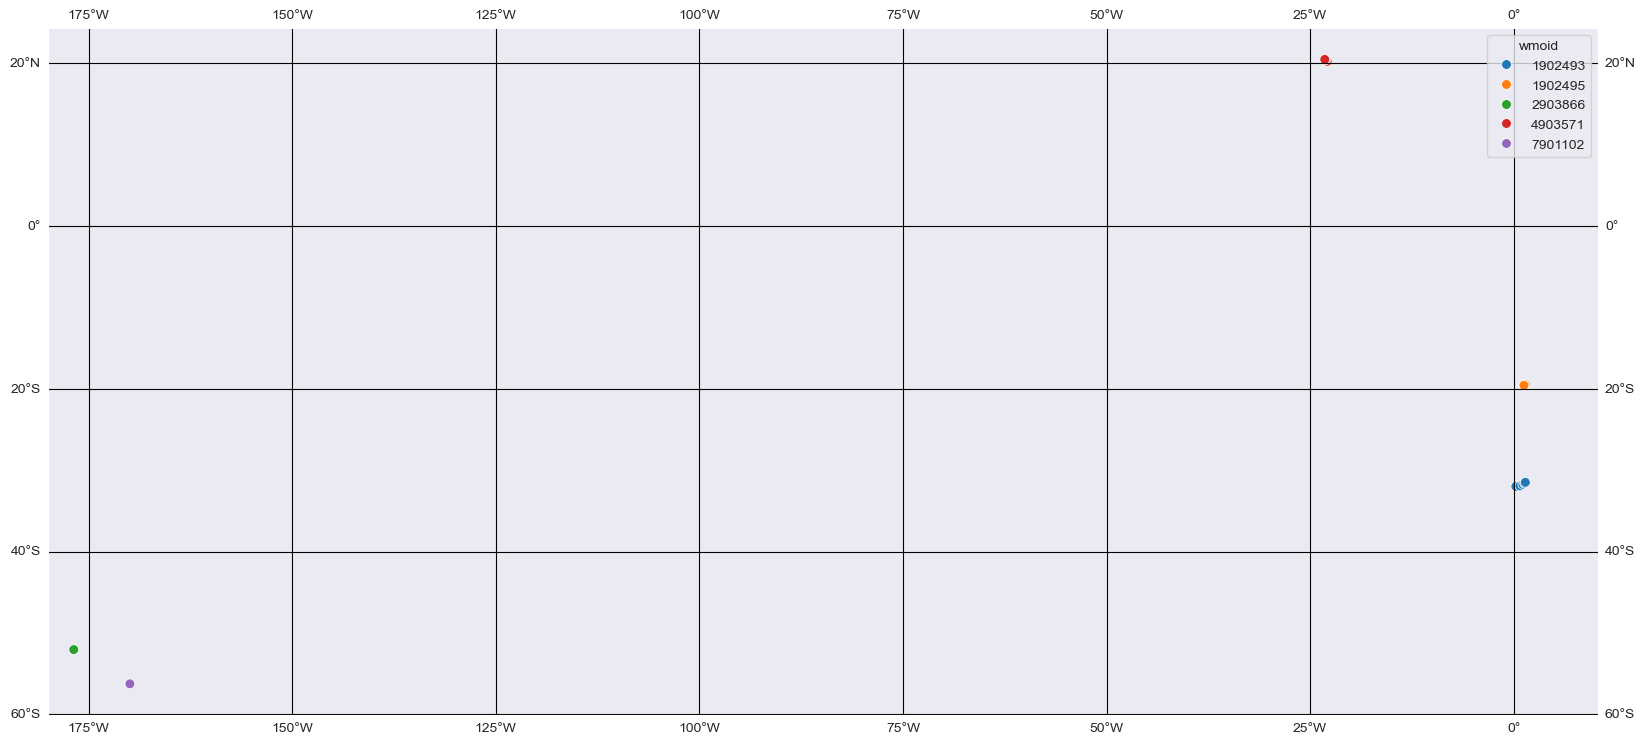

In [18]:
# Map locations, colored by WMOID
# Note: simple_map was modified to use Seaborn scatterplot and also pass in marker
simple_map(dfmap.lon, dfmap.lat, z=dfmap.wmoid, s=50, polygon=polygon, title=dataSetName)
plt.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0, markerscale=2)


In [19]:
fig = px.scatter_geo(dfmap, lat=dfmap.lat, lon=dfmap.lon, hover_name='_id', color='wmoid', projection='equirectangular', opacity=0.7)
fig.update_yaxes(title='latitude', visible=True, showticklabels=True)
fig.update_geos(fitbounds="geojson", showframe=True, lataxis_showgrid=True, lonaxis_showgrid=True, lataxis_dtick=1.0, lonaxis_dtick=1.0,  showland=True, showcoastlines=True, showcountries=True, showlakes=True, showocean=False)
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.show()

In [37]:
from ast import literal_eval

polygon = '[[]]'
# dfmap.sort_values(by=['year'], inplace=True)

dfmap.sort_values('wmoid', inplace=True)
px.set_mapbox_access_token(open("/Users/ericrehm/.mapbox_token/bgcargo").read())
fig = px.scatter_mapbox(dfmap, lat=dfmap.lat, lon=dfmap.lon, hover_name='_id', color='wmoid', opacity=1)
# fig.update_yaxes(title='latitude', visible=True, showticklabels=False)
fig.update_geos(fitbounds="geojson", showframe=True)
fig.update_layout(legend= {'itemsizing': 'constant'}, autosize=False, width=1000, height=800,
    mapbox=dict(
        bearing=0,
        pitch=0,
        zoom=4.8,
        style="satellite",
        # style="carto-positron",
        layers=[{
            "below":'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source":["https://basemap.nationalmap.gov/arcgis/rest/services/USGSHydroCached/MapServer/tile/{z}/{y}/{x}"]
        },
        {
            'below': "traces", 
            'source': {
                'type': "FeatureCollection",
                'features': [{
                    'type': "Feature",
                    'geometry': {
                        'type': "MultiPolygon",
                        'coordinates': [[literal_eval(polygon)]]
                    }
                }]
            },
            'type': "line", 'color': "royalblue"
        }])
    )
fig.show()

Turn our data into a list of dataframes, and plot with color by QC:

In [27]:
# dataSetName = 'JAMSTEC NAVIS_A'
# dataSetName = 'NAVIS_A fDOM Validation Set'
dataSetName = 'PacificNW APEX'

(dfm, dfmap) = dfRead(dataSetName)

# Plot dfm, facety by year
dfm.sort_values(by=['year'], inplace=True)
# dfmm = dfm.loc[dfm.year.isin(['2017','2022','2023'])].copy()
# dfmmm = dfmm.loc[dfmm.wmoid.isin(['6904240', '6904241', '6901486', '6901480'])]

fig = px.scatter(dfm, x='cdom', y='pressure', color='wmoid', facet_col='year', hover_data=['id'],  facet_col_wrap=5, title=dataSetName)
# fig = px.scatter(dfm, x='cdom', y='pressure', color='wmoid',  hover_data=['id'],  facet_col_wrap=5, title=dataSetName)
fig.update_traces(marker={'size': 1.5})    
fig.update_xaxes(range=[0,20])
fig.update_yaxes(autorange='reversed')
fig.update_layout(width=1000, height=1000, legend= {'itemsizing': 'constant'})

fig.show()

PacificNW APEX_dfm.csv


In [ ]:
# Plot dfm, facety by year, but add on simulated data from 1010 - 2000 m.


# p = np.concatenate((np.arange(1,1001), np.arange(1010,2010,10)))
p = np.arange(1010,2010,1)

sf = 0.09
darkCounts = np.arange(35,63,7)
noiseAmp = 1.1
counts = 62 * np.ones(p.size)

dfall = dfm.copy()

for yr in dfm.year.unique() :
    for dark in darkCounts :
        noise = np.random.normal(0, noiseAmp, p.size)
        cdom = sf*(np.round(counts+noise) - dark)
        print(f'dark: {dark}, mean_cdom = {sf*(counts[0]-dark):0.1f}')

        df = pd.DataFrame([])
        df['cdom'] = cdom
        df['pressure'] = p
        df['wmoid'] = dark
        df['year'] = yr
        df['id'] = f'{dark}'
        dfall = pd.concat([dfall, df], axis=0)

dfall.wmoid = dfall.wmoid.astype('category')
dfall.year = dfall.year.astype('category')

fig = px.scatter(dfall, x='cdom', y='pressure', color='wmoid', facet_col='year', hover_data=['id'],  facet_col_wrap=5, title=dataSetName)
fig.update_traces(marker={'size': 2})    
fig.update_xaxes(range=[-2,4])
fig.update_yaxes(autorange='reversed')
fig.update_layout(width=1200, height=1000, legend= {'itemsizing': 'constant'})



dark: 35, mean_cdom = 2.4
dark: 42, mean_cdom = 1.8
dark: 49, mean_cdom = 1.2
dark: 56, mean_cdom = 0.5
dark: 35, mean_cdom = 2.4
dark: 42, mean_cdom = 1.8
dark: 49, mean_cdom = 1.2
dark: 56, mean_cdom = 0.5
dark: 35, mean_cdom = 2.4
dark: 42, mean_cdom = 1.8
dark: 49, mean_cdom = 1.2
dark: 56, mean_cdom = 0.5


In [ ]:
# Plot only simulated data from 1010-2000 m

p = np.concatenate((np.arange(1,1001), np.arange(1010.0,2010.0,10)))
# p = np.arange(1,1001)

sf = 0.09
darkCounts = np.arange(35,63,7)
noiseAmp = 1.1
counts = 62 * np.ones(p.size);

dfall = pd.DataFrame([])

for dark in darkCounts :
    noise = np.random.normal(0, noiseAmp, p.size)
    cdom = sf*(np.round(counts+noise) - dark)
    print(f'dark: {dark}, mean_cdom = {sf*(counts[0]-dark):0.1f}')
    df = pd.DataFrame([])
    df['cdom'] = cdom
    df['pressure'] = p
    df['dark'] = dark
    dfall = pd.concat([dfall, df])

dfall.dark = dfall.dark.astype('category')

fig = px.scatter(dfall, x='cdom', y='pressure', color='dark', title=f'Synthetic: counts={counts[0]}')
fig.update_traces(marker={'size': 2})    
fig.update_xaxes(range=[-2,4])
fig.update_yaxes(autorange='reversed')
fig.update_layout(width=330, height=1000, legend= {'itemsizing': 'constant'})



dark: 35, mean_cdom = 2.4
dark: 42, mean_cdom = 1.8
dark: 49, mean_cdom = 1.2
dark: 56, mean_cdom = 0.5


Or, filter by QC before plotting:

Plot map of all BGC profile locations in 10 day span:

In [ ]:
params = {
        'startDate': '2022-10-31T00:00:00Z',
        'endDate': '2022-11-11T00:00:00Z',
        'source': 'argo_bgc'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)
longitudes = [x['geolocation']['coordinates'][0] for x in d]
latitudes  = [x['geolocation']['coordinates'][1] for x in d]

simple_map(longitudes,latitudes)

Query what variables are available for a certain platform

In [29]:
params = {
    'platform': '2903866',
    'source': 'argo_bgc',
    'data':'cdom,salinity'
    }
print(params)
d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

print(d[0])
metaOptions = {
    'id': d[0]['metadata'][0]
}
print(metaOptions)
md = avh.query('argo/meta', options=metaOptions, apikey=API_KEY, apiroot=API_PREFIX)
print(md[0])
print(md[0]['platform_type'])


{'platform': '2903866', 'source': 'argo_bgc', 'data': 'cdom,salinity'}
{'_id': '2903866_001', 'geolocation': {'type': 'Point', 'coordinates': [-176.8279, -52.0356]}, 'basin': 10, 'timestamp': '2024-04-14T17:05:29.001Z', 'date_updated_argovis': '2024-04-20T10:32:41.006Z', 'source': [{'source': ['argo_bgc'], 'url': 'ftp://ftp.ifremer.fr/ifremer/argo/dac/aoml/2903866/profiles/SR2903866_001.nc', 'date_updated': '2024-04-20T09:01:32.000Z'}, {'source': ['argo_core'], 'url': 'ftp://ftp.ifremer.fr/ifremer/argo/dac/aoml/2903866/profiles/R2903866_001.nc', 'date_updated': '2024-04-19T22:32:14.000Z'}], 'cycle_number': 1, 'geolocation_argoqc': 1, 'profile_direction': 'A', 'timestamp_argoqc': 1, 'vertical_sampling_scheme': 'Primary sampling: mixed [deep: discrete, shallow:averaged]', 'data': [[2.55464, 2.52561, 2.55464, 2.58367, 2.6127, 2.58367, 2.58367, 2.58367, 2.55464, 2.52561, 2.6127, 2.52561, 2.55464, 2.58367, 2.58367, 2.52561, 2.52561, 2.58367, 2.55464, 2.64173, 2.52561, 2.55464, 2.58367, 2.58

In [64]:
print(d)
variables = set({})
for i in range(len(d)):
    if 'data_info' in d[i]:
        variables.update(d[i]['data_info'][0])
print(variables)

[{'_id': '2903354_207', 'geolocation': {'type': 'Point', 'coordinates': [163.252, 45.434]}, 'basin': 2, 'timestamp': '2020-03-12T12:04:26.999Z', 'date_updated_argovis': '2023-02-07T08:30:51.196Z', 'source': [{'source': ['argo_bgc'], 'date_updated': '2023-02-05T11:36:51.000Z', 'url': 'ftp://ftp.ifremer.fr/ifremer/argo/dac/jma/2903354/profiles/SR2903354_207.nc'}, {'source': ['argo_core'], 'date_updated': '2023-02-05T00:15:05.000Z', 'url': 'ftp://ftp.ifremer.fr/ifremer/argo/dac/jma/2903354/profiles/R2903354_207.nc'}], 'cycle_number': 207, 'geolocation_argoqc': 1, 'profile_direction': 'A', 'timestamp_argoqc': 1, 'vertical_sampling_scheme': 'Primary sampling: averaged [2 dbar bin average for 1 Hz CTD]', 'data': [[0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.

Query a platform and plot data for a variable of interest.  The data is first interpolated onto a regular vertical grid and then a shaded plot of time vs pressure is shown. 

In [37]:
params = {
    'platform': '5907061',
    'data': 'cdom'
}

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

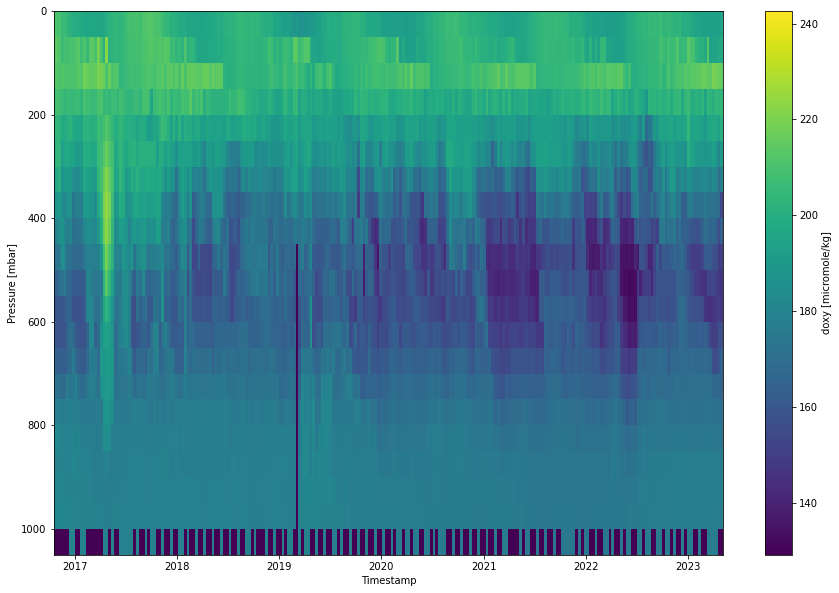

In [ ]:
argo_heatmap(d, 'doxy', list(range(0,1001))[0::50])

In [4]:
# Instead of using polygon, retrieve data using a list of floats (WMOids)
#
# Note that none of mapping routines above work since they all require a polygon.

doCorrection = False 
CorrectionFactor = np.array([])
ScalingFactor = np.array([])

# platforms = ['6901521','6901523','6'901480', '6901481', '6901482', '6901484', '6901485', '6901486', '6901517', '6901519']
# dataSetName = 'Nathan'
# platforms = ['5907061']
# dataSetName = 'MBARI'
# platforms = ['4903026', '5906765']
# dataSetName = 'KenJ1'
# platforms = ['5904477', '5904847']
# dataSetName = 'KenJ2'
# platforms = ['5906304', '5906310']
# dataSetName = 'KenJ3'
# platforms = ['4903365', '5904479']
# dataSetName = 'KenJ3b'
# platforms = ['4903365', '6901516', '6904185']  # MCOMS, PROVOR_III, PROVOR,


# dataSetName = "Out-of-date Scale Factor (PROVOR_IV)"
# platforms = ['6902967', '4901806']
# dataSetName = "Typo Scale Factor (PROVOR III)"
# platforms = ['7901007']
# dataSetName = "CDOM Channel Incorrectly Marked as BB"
# platforms = ['6903576']


# dataSetName = 'LOV Bad LED'

# dataSetName = 'Advisory: Out-of-Tolerance UV LED (ids so far)'
# platforms = ['6904240', '6904241', '4903634', '1902578', '5906970', '3902471', '2903783', '1902593', '4903657']
# platforms = ['6904240','6904241','4903634', '1902578','5906970','3902471','1902593'] # 
# dataSetName = 'SIO'
# platforms = ['6904241', '4903660', '4903740']
# dataSetName = 'SIO-CROVER'
# platforms = ['4903026', '5906765', '5906766', '5906767']
# dataSetName = 'SIO_CDOM'
# platforms = ['5906765']
# dataSetName = 'SIO-5906765'
# dataSetName = 'Test Bad LED'
# platforms = ['6904240', '7900947', '5906767']
# platforms = ['6904240', '6903825', '6903828', '7900943', '7900947', '5906767']

# dataSetName = 'LOV Good LED'
# platforms = ['6901480','6901486', '6901489', '6901521', '6901523', '6901527']
# dataSetName = 'REMA Noise Supression Introduced (early 2019)'
# platforms = ['6901486', '7901006', '7901007', '6904182', '6904187', '6903874', '5906624', '2902822', '6903550', '6903124']  #backwards in time. all ok except 7046 (file)
# platforms = ['6901486', '6903551', '6903550',  '6903124', '6902907', '2902753']  #backwards in time. all ok except 7046 (file)
# dataSetName = 'REMA LED Noise Suppression after ~6903124'
# platforms = ['6903825', '6903551', '6903550',  '6903124', '6902907',]  #backwards in time. all ok except 7046 (file)


# platforms = ['6903124']  # Rubicon float (last with noise)
# platforms = ['6901486', '6903825', '7900947']  #backwards from most recently deployed
# platforms = ['5903102']


# dataSetName = 'EuroArgo : Cal Date 8/2020'
# platforms = np.array(['5906765', '6903874','6903875','6903876','6903877',  '6903878','6903590',  '6903591','6903577', '6903578', '6903579',
#              '7901007','7901006'])

# subset = [8,9,10,11,12]
# subset = [9]
# startDate = '2023-10-01T00:00:00Z'
# endDate = ''

# dataSetName = 'NAVIS_A test set'
# platforms = np.array([5906310, 5906311,5906304,5906309,5906307,5906308,5906036,5906026,5906305,5906306,5906035])
# subset = [0,1,2,3,4,5,6,7,8,9,10]
# startDate = '2019-05-01T00:00:00Z'
# endDate = ''

# dataSetName = 'NAVIS_A test set2'
# platforms = np.array([1902303, 5906508, 5906442, 5906563,5906565,5906537,4903500,4903499,5906539,5906540,7901009,2903459,2903462,2903461,2903463,1902497,1902499])
# subset = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
# startDate = '2019-05-01T00:00:00Z'
# endDate = ''

# dataSetName = 'NAVIS_A fDOM Training Set'
# platforms = np.array([2903213,2903329,2903393,2903396,2903666,2903669,2903700,5906596,5906597])
# subset = list(range(0,len(platforms)))
# startDate = '2017-01-01T00:00:00Z'
# endDate = ''
# doCorrection = True
# # CorrectionFactor = np.array([0.40,0.40,0.40,0.40,0.40,0.40, 0.93,0.93,1.00])   #derived from Deep CDOM
# CorrectionFactor = np.array([0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.94, 0.94, 0.94])  # derived from SF drift
# ScalingFactor    = np.array([1,1,1,1,1,1,1,1,1/5.62])*5.62

# dataSetName = 'NAVIS_A fDOM Validation Set'
# platforms = np.array([5906035,5906036,5906309,5906304,5906306,5906308,1902303,5906305,5906311,5906310,5906026,5906508,5906442,5906307,5906563,5906565,5906537,4903500,4903499,5906539,5906540,7901009,2903459,2903462,2903461,2903463,1902497,1902499])
# subset = list(range(0,len(platforms)))
# # startDate = '2024-01-01T00:00:00Z'
# startDate = '2017-01-01T00:00:00Z'
# endDate = ''
# doCorrection = True
# # CorrectionFactor = np.array([0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.70,0.70,0.70,0.70,0.70,0.80,0.80,0.80,0.83,0.83,0.83,0.83,0.95,0.95,0.95,0.95,0.95,1.00,1.00])
# # CorrectionFactor = np.array([0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.70,0.70,0.70,0.70,0.70,0.93,0.93,0.93,0.95,0.95,0.95,0.95,1.07,1.07,1.07,1.07,1.07,1.00,1.00])  # derived from Deep CDOM
# CorrectionFactor = np.array([0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.88,0.88,0.88,0.90,0.90,0.94,0.94,0.94,1.0,1.0,1.0,1.0,1.01,1.01,1.01,1.01,1.01,1.00,1.00]) 
# ScalingFactor    = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1/5.62,1/5.62])*5.62



dataSetName = 'NAVIS_A KenJ-20240422'
platforms = np.array([1902493, 192494, 1902495, 2903863, 2903866, 4903571, 4903752, 7901102])
subset = list(range(0,len(platforms)))
# startDate = '2024-01-01T00:00:00Z'
startDate = '2023-01-01T00:00:00Z'
endDate = ''
doCorrection = True
CorrectionFactor = np.array([1,1,1,1,1,1,1,1]) 
ScalingFactor    = np.array([1,1,1,1,1,1,1,1])


(dfm, dfmap) = getProfilesFromFloats(platforms[subset], startDate, endDate, doCorrection, CorrectionFactor, ScalingFactor)
dfSave(dataSetName, dfm, dfmap)



1902493
{'startDate': '2023-01-01T00:00:00Z', 'endDate': '2024-04-23T20:33:07Z', 'platform': 1902493, 'data': 'cdom,salinity,temperature', 'source': 'argo_bgc'}
192494
{'startDate': '2023-01-01T00:00:00Z', 'endDate': '2024-04-23T20:33:07Z', 'platform': 192494, 'data': 'cdom,salinity,temperature', 'source': 'argo_bgc'}
1902495
{'startDate': '2023-01-01T00:00:00Z', 'endDate': '2024-04-23T20:33:07Z', 'platform': 1902495, 'data': 'cdom,salinity,temperature', 'source': 'argo_bgc'}
2903863
{'startDate': '2023-01-01T00:00:00Z', 'endDate': '2024-04-23T20:33:07Z', 'platform': 2903863, 'data': 'cdom,salinity,temperature', 'source': 'argo_bgc'}
2903866
{'startDate': '2023-01-01T00:00:00Z', 'endDate': '2024-04-23T20:33:07Z', 'platform': 2903866, 'data': 'cdom,salinity,temperature', 'source': 'argo_bgc'}
4903571
{'startDate': '2023-01-01T00:00:00Z', 'endDate': '2024-04-23T20:33:07Z', 'platform': 4903571, 'data': 'cdom,salinity,temperature', 'source': 'argo_bgc'}
4903752
{'startDate': '2023-01-01T00

In [5]:
# Plot it
# var = 'cdom'
# var = 'cdom_sc'
var = 'cdom_adj'
(dfm, dfmap) = dfRead(dataSetName)
plotdfmByYear(dataSetName, dfm, var)

NAVIS_A KenJ-20240422_dfm.csv


In [6]:
# Plot it
var = 'cdom'
# var = 'cdom_sc'
# var = 'cdom_adj'
var = 'temperature'
(dfm, dfmap) = dfRead(dataSetName)
plotdfmXYByYear(dataSetName, dfm, 'salinity', var)

NAVIS_A KenJ-20240422_dfm.csv


In [22]:
# Reference
# dataSetName = 'NAVIS_A fDOM Training Set'
dataSetName = 'NAVIS_A fDOM Validation Set'
dataSetName = 'NAVIS_A KenJ-20240422'

(dfm, dfmap) = dfRead(dataSetName)
# ref = 5906597
dfref = dfm[(dfm.pressure > 1900)]
# # print(type(dfm.wmoid[0]))
# cdom2000ref = dfref.cdom_adj.mean(skipna=True)
# cdom2000std = dfref.cdom_adj.std(skipna=True)
cdom2000ref = dfref.cdom_adj.mean(skipna=True)
cdom2000std = dfref.cdom_adj.std(skipna=True)
print(f'cdom2000ref={cdom2000ref}, std={cdom2000std}, CoV = {100*cdom2000std/cdom2000ref}%, refN={len(dfref.wmoid)}')



NAVIS_A KenJ-20240422_dfm.csv
cdom2000ref=5.232738285714286, std=0.4242388253614156, CoV = 8.107396208207374%, refN=35


In [1]:


# platforms = np.array([2903213,2903329,2903393,2903396,2903666,2903669,2903700,5906596,5906597])
platforms = np.array([2903213,2903329,2903393,2903396,2903666,2903669])  

# platforms = np.array([2903700,5906596])

doValidate = True
if doValidate:
    dataSetName = 'NAVIS_A fDOM Validation Set'
    (dfm, dfmap) = dfRead(dataSetName)
    # platforms = np.array([7901009,2903459,2903462,2903461,2903463]) # 0.95  --> 1.07  (1990)
    # platforms = np.array([4903500,4903499,5906539,5906540]) #0.85 --> 0.95 NOT  (1790)
    # platforms = np.array([5906310, 5906026,5906508,5906442,5906307,5906563]) #0.70 --> 0.71 NOT (1990)
    # platforms = np.array([5906310, 5906026,5906508]) #0.70 --> 0.71 NOT (1990)
    platforms = np.array([5906442,5906307,5906563]) #0.70 --> 0.71 NOT (1990)
    # platforms = np.array([5906565, 5906537])  #0.85 --> 0.93  (1750)




cdom2000 = np.array([])

for platform in platforms :
    df1 = dfm[(dfm.wmoid == platform) & (dfm.pressure > 1750)]
    cdom = df1.cdom.mean(skipna=True)*5.62
    print(platform, cdom/5.62, cdom)
    cdom2000 = np.concatenate((cdom2000, [cdom]), axis=0)
    
cdom2000 = np.nanmean(cdom2000)
print(cdom2000 )
print(cdom2000ref/cdom2000)



NameError: name 'np' is not defined

In [ ]:


# Plot dfm, facety by year
# dfm.loc[dfm.wmoid=='5906304','cdom'] *= (0.006832/0.01099) 
# dfm.loc[dfm.wmoid=='6902967','cdom'] *= (0.0662/0.0903)
# dfm.loc[dfm.wmoid=='4901806','cdom'] *= (0.0708/0.0906)
# dfm.loc[dfm.wmoid=='7901007','cdom'] *= (0.0884/0.00884)
# dfm.loc[dfm.wmoid=='6903576','cdom'] *= (0.0908/ 6.34E-06)


dfm.sort_values(by=['year'], inplace=True)

# dfmm = dfm.loc[dfm.year.isin(['2017','2022','2023'])].copy()
# dfmmm = dfmm.loc[dfmm.wmoid.isin(['6904240', '6904241', '6901486', '6901480'])]
# 
# fig = px.scatter(dfm, x='cdom', y='pressure', color='wmoid', facet_col='year', hover_data=['id'],  facet_col_wrap=5, title=dataSetName)
fig = px.scatter(dfm, x='cdom', y='pressure', color='wmoid', hover_data=['id'],  title=dataSetName)
fig.update_traces(marker={'size': 1.5})    
fig.update_xaxes(range=[-2,4])
fig.update_yaxes(autorange='reversed')
fig.update_layout(width=400, height=600, legend= {'itemsizing': 'constant'})

fig.show()

dfm[dfm.wmoid=='5906304'].cdom *= (0.006832/0.01099) 



# Colocating BGC profiles with other data

We can co-locate Argo BGC profiles with other measurements and phenomena, like tropical cyclones. For example, let's find all the BGC profiles near hurricane Maria in 2017, and plot some BGC measurements before and after the hurricane passed:

In [ ]:
tc_param = {
    'startDate': '2017-09-01T00:00:00Z',
    'endDate': '2017-10-01T00:00:00Z',
    'name': 'MARIA',
    'data': 'wind,surface_pressure'
}

tc = avh.query('tc', options=tc_param, apikey=API_KEY, apiroot=API_PREFIX)

tc_lon = [x['geolocation']['coordinates'][0] for x in tc]
tc_lat = [x['geolocation']['coordinates'][1] for x in tc]
tc_wind = [x['data'][x['data_info'][0].index('wind')][0] for x in tc]

In [ ]:
argo_bgc = []

for h in tc:
    colo_argo = {
        'center': str(h['geolocation']['coordinates'][0]) + ',' + str(h['geolocation']['coordinates'][1]),
        'radius': 52,
        'startDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=-6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'endDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'data': 'all',
        'source': 'argo_bgc'
    }
    p = avh.query('argo', options=colo_argo, apikey=API_KEY, apiroot=API_PREFIX)

    if len(p) == 0:
        argo_bgc.append(None)
    else:
        print('Profile found adjacent to', h['geolocation']['coordinates'][0], h['geolocation']['coordinates'][1])
        argo_bgc.append(p)

In [ ]:
floats = []
colorBefore = 'red'
colorAfter = 'purple'
bracket_points = []
for i, colo in enumerate(argo_bgc):
    buddyBefore = False
    buddyAfter = False
    if colo:
        hurrtime = avh.parsetime(tc[i]['timestamp']) 
        for p in colo:
            ptime = avh.parsetime(p['timestamp'])
            buddy={
                "lon": p['geolocation']['coordinates'][0],
                "lat": p['geolocation']['coordinates'][1],
            }
            if ptime < hurrtime:
                buddy['color'] = colorBefore
                buddyBefore = True
            else:
                buddy['color'] = colorAfter
                buddyAfter = True
            floats.append(buddy)
        if buddyBefore and buddyAfter:
            bracket_points.append(i)
simple_map(tc_lon, tc_lat, secondaries=floats, z=tc_wind)
        
hurrplot([bracket_points[0]], tc=tc, argo=argo_bgc, var='temperature',colorBefore = 'red',colorAfter = 'purple') 
hurrplot([bracket_points[0]], tc=tc, argo=argo_bgc, var='salinity',colorBefore = 'red',colorAfter = 'purple')

We can also colocate with a ship-based profile in a similar manner:

In [ ]:
cruise_params = {
    "cchdo_cruise": 2370,
    "woceline": "AR07W",
    "data": "temperature_btl"
}

cruise = avh.query('cchdo', options=cruise_params, apikey=API_KEY, apiroot=API_PREFIX)

In [ ]:
colo_argo_bgc = []
for cchdo_meas in cruise:
    bgc_param = {
        "center": str(cchdo_meas['geolocation']['coordinates'][0]) + ',' + str(cchdo_meas['geolocation']['coordinates'][1]),
        "radius": 50,
        "startDate": avh.parsetime((avh.parsetime(cchdo_meas['timestamp']) + timedelta(hours=-48))),
        "endDate": avh.parsetime((avh.parsetime(cchdo_meas['timestamp']) + timedelta(hours=+48))),
        "source": 'argo_bgc',
        "data": 'temperature'
    }

    prox = avh.query('argo', options=bgc_param, apikey=API_KEY, apiroot=API_PREFIX)
    
    if len(prox) != 0:
        colo_argo_bgc.append(prox)
    else:
        colo_argo_bgc.append(None)

In [ ]:
bgc_paths = []

for colo in colo_argo_bgc:
    if(colo is not None):
        bgc_paths.append({
            "lon": [x['geolocation']['coordinates'][0] for x in colo],
            "lat": [x['geolocation']['coordinates'][1] for x in colo]
        })
    
cchdo_longitudes = [x['geolocation']['coordinates'][0] for x in cruise]
cchdo_latitudes  = [x['geolocation']['coordinates'][1] for x in cruise]
simple_map(cchdo_longitudes,cchdo_latitudes, secondaries=bgc_paths, bounding_box=[-60,-45,53,63])


We can then plot variables of interest and compare between BGC and ship-based profiles:

In [ ]:
for i,ship_profile in enumerate(cruise):
    if colo_argo_bgc[i] is None:
        continue
    else:
        compare_plots([ship_profile], 'temperature_btl', colo_argo_bgc[i], 'temperature')